In [1]:
!pip install rouge_score

In [2]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input, Bidirectional, LSTM, Dropout, LayerNormalization, Lambda, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the dataset
def load_data(file_path):
    articles = []
    summaries = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            # First join words in each sentence, then join sentences in each paragraph
            article_text = ' '.join([' '.join(sentence) for paragraph in data['paragraphs'] for sentence in paragraph])
            summary_text = ' '.join([' '.join(sentence) for sentence in data['summary']])
            articles.append(article_text)
            summaries.append(summary_text)
    return articles, summaries


# Paths to one of the dataset's JSONL files (adjust for different folds)
train_file = '../input/indosum/indosum/train.01.jsonl'
dev_file = '../input/indosum/indosum/dev.01.jsonl'
test_file = '../input/indosum/indosum/test.01.jsonl'

# Load data
train_articles, train_summaries = load_data(train_file)
dev_articles, dev_summaries = load_data(dev_file)
test_articles, test_summaries = load_data(test_file)

In [4]:
print(f"jumlah data : {len(train_articles)}")
print(f"contoh artikel : {train_articles[0]}")
print(f"contoh summary artikel : {train_summaries[0]}")

jumlah data : 14262
contoh artikel : Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu . Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat . " Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) . Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga ta

In [5]:
# First, define special tokens with specific indices
PAD_TOKEN = '<pad>'  # 0
START_TOKEN = '<start>'  # 1
END_TOKEN = '<end>'  # 2
UNK_TOKEN = '<unk>'  # 3

def create_custom_tokenizer(texts):
    # Create word to index mapping
    word_counts = {}
    for text in texts:
        for word in text.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    
    # Sort words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create vocabulary with special tokens first
    word_index = {
        PAD_TOKEN: 0,
        START_TOKEN: 1,
        END_TOKEN: 2,
        UNK_TOKEN: 3
    }
    
    # Add remaining words
    for word, _ in sorted_words:
        if word not in word_index:
            word_index[word] = len(word_index)
    
    # Create reverse mapping
    index_word = {v: k for k, v in word_index.items()}
    
    return word_index, index_word

def texts_to_sequences(texts, word_index, max_length, add_special_tokens=False):
    sequences = []
    for text in texts:
        if add_special_tokens:
            sequence = [word_index[START_TOKEN]]
        else:
            sequence = []
            
        for word in text.split():
            sequence.append(word_index.get(word, word_index[UNK_TOKEN]))
            
        if add_special_tokens:
            sequence.append(word_index[END_TOKEN])
            
        sequences.append(sequence)
    
    # Pad sequences
    padded_sequences = pad_sequences(
        sequences,
        maxlen=max_length,
        padding='post',
        truncating='post',
        value=word_index[PAD_TOKEN]
    )
    
    return padded_sequences

In [6]:
max_article_len = 500
max_summary_len = 100

# Create and apply tokenizer
print("Creating tokenizer...")
word_index, index_word = create_custom_tokenizer(train_articles + train_summaries)
vocab_size = len(word_index)

print(f"Vocabulary size: {vocab_size}")
print("Sample special token IDs:")
print(f"PAD_TOKEN: {word_index[PAD_TOKEN]}")
print(f"START_TOKEN: {word_index[START_TOKEN]}")
print(f"END_TOKEN: {word_index[END_TOKEN]}")
print(f"UNK_TOKEN: {word_index[UNK_TOKEN]}")

# Convert texts to sequences
print("\nConverting texts to sequences...")
X_train = texts_to_sequences(train_articles, word_index, max_article_len, add_special_tokens=False)
Y_train = texts_to_sequences(train_summaries, word_index, max_summary_len, add_special_tokens=True)
X_dev = texts_to_sequences(dev_articles, word_index, max_article_len, add_special_tokens=False)
Y_dev = texts_to_sequences(dev_summaries, word_index, max_summary_len, add_special_tokens=True)

Creating tokenizer...
Vocabulary size: 120720
Sample special token IDs:
PAD_TOKEN: 0
START_TOKEN: 1
END_TOKEN: 2
UNK_TOKEN: 3

Converting texts to sequences...


In [7]:
# Prepare decoder input/output for training
Y_train_in = np.insert(Y_train, 0, 0, axis=1)[:, :-1]  # Shifted target sequences
Y_train_out = np.expand_dims(Y_train, -1)

# Training
batch_size = 64

In [31]:
# Summary generation function
def generate_summary(model, article_seq, word_index, index_word, max_summary_len, debug=False):
    start_token_id = word_index[START_TOKEN]
    end_token_id = word_index[END_TOKEN]
    
    # Initialize with start token
    summary_seq = [start_token_id]
    
    for _ in range(max_summary_len - 2):  # -2 to leave room for END token
        decoder_input = pad_sequences([summary_seq], maxlen=max_summary_len, padding='post', value=word_index[PAD_TOKEN])
        
        # Get model prediction
        output = model.predict([np.array([article_seq]), decoder_input], verbose=0)
        next_token_probs = output[0, len(summary_seq) - 1]
        
        # Get next token
        next_token = np.argmax(next_token_probs)
        
        # Print debug info
        if debug:
            top_3_indices = np.argsort(next_token_probs)[-3:][::-1]
            print("\nTop 3 predictions:")
            for idx in top_3_indices:
                word = index_word[idx]
                prob = next_token_probs[idx]
                print(f"{word} ({idx}): {prob:.4f}")
        
        # Break if END token or hit max length
        if next_token == end_token_id:
            break
            
        summary_seq.append(next_token)
        
        # Print current sequence
        current_words = [index_word[idx] for idx in summary_seq]
        if debug:
            print(f"Current sequence: {' '.join(current_words)}")
    
    # Convert to words (excluding special tokens)
    generated_words = []
    for token in summary_seq[1:]:  # Skip start token
        if token == end_token_id:
            break
        word = index_word[token]
        if word not in [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN]:
            generated_words.append(word)
    
    return ' '.join(generated_words)

def decode_references(Y_test, tokenizer):
    references = []
    for seq in Y_test:
        reference = ' '.join([tokenizer.index_word.get(idx, '') for idx in seq if idx != 0])
        references.append(reference)
    return references

# Convert test articles and summaries to sequences
X_test = texts_to_sequences(test_articles[:100], word_index, max_article_len, add_special_tokens=False)
Y_test = texts_to_sequences(test_summaries[:100], word_index, max_article_len, add_special_tokens=True)

In [9]:
# Function to compute ROUGE scores
def compute_rouge(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, cand in zip(references, candidates):
        score = scorer.score(ref, cand)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    # Average the scores
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores

## Transformer

In [10]:
# Define constants
d_model = 64  # Dimension of embeddings
num_heads = 8  # Number of attention heads
ff_dim = 512   # Feed-forward network dimension
num_layers = 4  # Number of Transformer blocks

In [11]:
# @register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)  # Pass additional arguments to the base Layer class
        self.position = position
        self.d_model = d_model

    def call(self, inputs):
        angle_rates = 1 / tf.pow(
            tf.cast(10000, tf.float32),
            (2 * tf.cast(tf.range(self.d_model) // 2, tf.float32)) / tf.cast(self.d_model, tf.float32),
        )
        position_indices = tf.cast(tf.range(self.position)[:, tf.newaxis], tf.float32)
        angle_rads = position_indices * angle_rates
        angle_rads = tf.where(tf.range(self.d_model) % 2 == 0, tf.sin(angle_rads), tf.cos(angle_rads))
        pos_encoding = angle_rads[tf.newaxis, ...]
        return inputs + tf.cast(pos_encoding, inputs.dtype)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model,
        })
        return config


In [12]:
# Transformer Encoder Block
def transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head Self-Attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-Forward Network
    ffn = Dense(ff_dim, activation='relu')(attention)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    outputs = LayerNormalization(epsilon=1e-6)(attention + ffn)

    return outputs

In [13]:
# Transformer Decoder Block
def transformer_decoder(inputs, encoder_output, d_model, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head Self-Attention (Decoder Input)
    attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)

    # Multi-head Attention (Encoder-Decoder Attention)
    attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, encoder_output)
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = LayerNormalization(epsilon=1e-6)(attention1 + attention2)

    # Feed-Forward Network
    ffn = Dense(ff_dim, activation='relu')(attention2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    outputs = LayerNormalization(epsilon=1e-6)(attention2 + ffn)

    return outputs

In [14]:
def create_transformer_model(vocab_size, max_article_len, max_summary_len):
    # Increase model capacity
    d_model = 256  # Increased from 64
    num_heads = 8
    ff_dim = 1024  # Increased from 512
    num_layers = 6  # Increased from 4
    
    encoder_inputs = Input(shape=(max_article_len,))
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=d_model)(encoder_inputs)
    encoder_positional = PositionalEncoding(max_article_len, d_model)(encoder_embedding)
    
    # Add initial dropout and layer normalization
    encoder_output = Dropout(0.1)(encoder_positional)
    encoder_output = LayerNormalization(epsilon=1e-6)(encoder_output)
    
    for _ in range(num_layers):
        encoder_output = transformer_encoder(encoder_output, d_model, num_heads, ff_dim)
    
    decoder_inputs = Input(shape=(max_summary_len,))
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=d_model)(decoder_inputs)
    decoder_positional = PositionalEncoding(max_summary_len, d_model)(decoder_embedding)
    
    # Add initial dropout and layer normalization
    decoder_output = Dropout(0.1)(decoder_positional)
    decoder_output = LayerNormalization(epsilon=1e-6)(decoder_output)
    
    for _ in range(num_layers):
        decoder_output = transformer_decoder(decoder_output, encoder_output, d_model, num_heads, ff_dim)
    
    decoder_output = LayerNormalization(epsilon=1e-6)(decoder_output)
    decoder_outputs = Dense(vocab_size)(decoder_output)
    
    # Use lower temperature for more focused predictions
    temperature = 0.8
    decoder_outputs = Lambda(lambda x: x / temperature)(decoder_outputs)
    decoder_outputs = Activation('softmax')(decoder_outputs)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [15]:
model_transformer = create_transformer_model(vocab_size, max_article_len, max_summary_len)
model_transformer.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_transformer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 256)  │ 30,904,320 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 500, 256)  │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500, 256)  │          0 │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 500, 256)  │        512 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 256)  │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500, 256)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 500, 1024) │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 500, 256)  │    262,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 500, 256)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 256)  │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500, 256)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 500, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 256)  │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 500, 1024) │    263,168 │ layer_normalizat

 Total params: 137,021,328 (522.69 MB)

 Trainable params: 137,021,328 (522.69 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_transformer = model_transformer.fit(
    [X_train, Y_train_in],  # Inputs: Encoder input and decoder input
    Y_train_out,            # Output: Decoder target output
    validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)),
    batch_size=16,
    epochs=5,
    # callbacks=[create_checkpoint_callback("transformer-last-epoch.keras")]
)

Epoch 1/5


I0000 00:00:1734947367.952865    1857 service.cc:145] XLA service 0x797fe8005610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734947367.952907    1857 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734947367.952911    1857 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734947370.969058    1857 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734947415.234796    1887 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_102', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1734947415.240029    1888 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_639', 2132 bytes spill stores, 2132 bytes spill loads

I0000 00:00:173

891/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3151 - loss: 7.3826

W0000 00:00:1734948397.430926    1855 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734948438.527614    1973 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_649', 40 bytes spill stores, 32 bytes spill loads

I0000 00:00:1734948442.785599    1974 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_649', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734948445.379042    1975 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_162', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1734948448.382164    1973 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_102', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1734948449.959455   

892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3151 - loss: 7.3811

W0000 00:00:1734948518.952725    1857 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734948537.215472    1856 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734948543.734243    2079 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_116', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1734948549.808650    2079 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_128', 228 bytes spill stores, 228 bytes spill loads

I0000 00:00:1734948551.637612    2078 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_142', 1980 bytes spill stores, 1980 bytes spill loads

I0000 00:00:1734948551.949485    

892/892 ━━━━━━━━━━━━━━━━━━━━ 1223s 1s/step - accuracy: 0.3151 - loss: 7.3796 - val_accuracy: 0.3294 - val_loss: 5.9136
Epoch 2/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 925s 1s/step - accuracy: 0.3710 - loss: 5.0536 - val_accuracy: 0.3176 - val_loss: 6.1177
Epoch 3/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 927s 1s/step - accuracy: 0.4510 - loss: 4.2418 - val_accuracy: 0.3073 - val_loss: 7.6265
Epoch 4/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 925s 1s/step - accuracy: 0.5318 - loss: 3.2175 - val_accuracy: 0.3042 - val_loss: 8.5002
Epoch 5/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 925s 1s/step - accuracy: 0.5772 - loss: 2.7245 - val_accuracy: 0.3040 - val_loss: 9.2493


In [23]:
def compare_models_plot(histories, labels):
    if len(histories) != len(labels):
        raise ValueError("The number of histories and labels must match.")

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        epochs = range(1, len(history.history["accuracy"]) + 1)
        plt.plot(epochs, history.history["accuracy"], label=f'Training Accuracy {label}')
        plt.plot(epochs, history.history["val_accuracy"], linestyle='--', label=f'Validation Accuracy {label}')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        epochs = range(1, len(history.history["loss"]) + 1)
        plt.plot(epochs, history.history["loss"], label=f'Training Loss {label}')
        plt.plot(epochs, history.history["val_loss"], linestyle='--', label=f'Validation Loss {label}')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

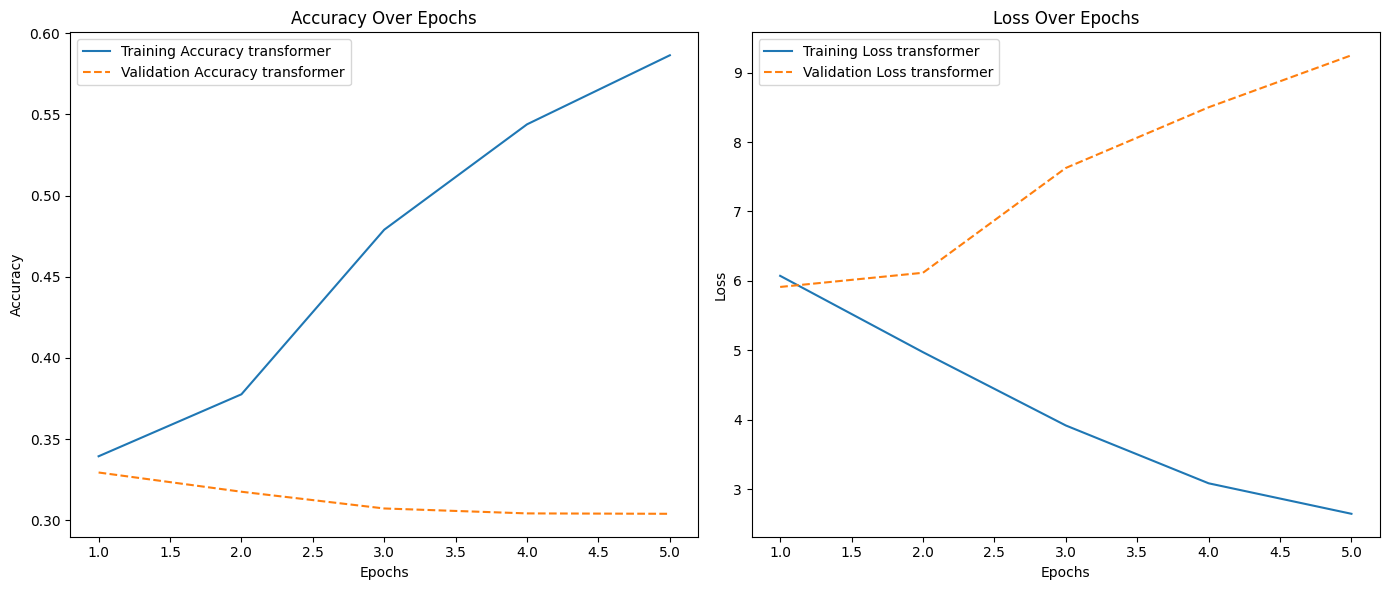

In [18]:
compare_models_plot([history_transformer], ["transformer"])

In [32]:
# Test generation
print("\nTesting generation...")
test_article = X_train[0]
generated = generate_summary(model_transformer, test_article, word_index, index_word, max_summary_len, debug=True)
print(f"\nGenerated summary: {generated}")
print(f"Original summary: {train_summaries[0]}")


Testing generation...

Top 3 predictions:
<pad> (0): 0.3912
<start> (1): 0.2900
<end> (2): 0.0204
Current sequence: <start> <pad>

Top 3 predictions:
<pad> (0): 0.8811
<start> (1): 0.0872
Minggu (250): 0.0007
Current sequence: <start> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9314
<start> (1): 0.0204
Minggu (250): 0.0017
Current sequence: <start> <pad> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9420
<start> (1): 0.0070
Minggu (250): 0.0018
Current sequence: <start> <pad> <pad> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9525
<start> (1): 0.0041
Minggu (250): 0.0013
Current sequence: <start> <pad> <pad> <pad> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9600
<start> (1): 0.0035
pada (18): 0.0010
Current sequence: <start> <pad> <pad> <pad> <pad> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9659
<start> (1): 0.0044
pada (18): 0.0007
Current sequence: <start> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Top 3 predictions:
<pad> (0): 0.9631
<start> (1): 0.0048
Minggu (250): 0.0008
Curr

In [34]:
print("Generating summaries for the test set...")
generated_summaries = []
x = 5
for i in range(x):
    generated_summary =  generate_summary(model_transformer, X_test[i], word_index, index_word, max_summary_len)
    print(f"Generated Summary {i+1}/{x} : {generated_summary}")
    generated_summaries.append(generated_summary)

Generating summaries for the test set...
Generated Summary 1/5 : 
Generated Summary 2/5 : 
Generated Summary 3/5 : 
Generated Summary 4/5 : 
Generated Summary 5/5 : 
